# 머신러닝 전 데이터 전처리
----
* (1) 목표 변수 정의 -> 마약 범죄 + 강력범죄
* (2) 사용하지 않을 칼럼 제거
* (3) 데이터 타입 변환 필요한 칼럼 처리
* (4) 이상치 처리
* (5) 비슷한 칼럼 간 다중공선성 여부 확인하기
* (6) 최종 데이터 타입 변환 및 범주형 변수 인코딩

## (1) 목표 변수 정의: 마약범죄 예측

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/final_pj/data_250409.csv")

In [ ]:
# 마약 관련 범죄로 간주할 범주 리스트
narcotics_types = {'NARCOTICS', 'OTHER NARCOTIC VIOLATION'}

# 메모리 최적화를 위해 numpy의 vectorized 연산 사용
# is_narcotics 컬럼 생성: Primary Type이 마약 관련이면 1, 아니면 0
df['is_narcotics'] = np.where(df['Primary Type'].isin(narcotics_types), 1, 0).astype(np.uint8)

In [ ]:
# 데이터 불균형 확인 -> 마약범죄가 아닌 경우(0)가 더 많음
df['is_narcotics'].value_counts()

,count
is_narcotics,
0,5496146
1,674667


## (2) 사용하지 않을 칼럼 제거

In [ ]:
df.columns

Index(['Unnamed: 0', 'ID', 'Case Number', 'Date', 'Block', 'IUCR',
       'Primary Type', 'Description', 'Location Description', 'Arrest',
       'Domestic', 'Beat', 'District', 'Ward', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Area Code', 'is_narcotics'],
      dtype='object')

In [ ]:
# 드랍할 칼럼 리스트
drop_columns = [
    'Unnamed: 0', 'Updated On', 'ID', 'Case Number', 'Block', 'Latitude', 'Longitude', 'Location',
    'Date', 'Year', # 시간 관련 칼럼
    'Primary Type', 'Description',  'IUCR', 'FBI Code'  # 정답을 맞추는 데 너무 직접적인 정보를 담은 칼럼(넣으면 정확도 1.0 나옴)
]

# 칼럼 드랍
df = df.drop(columns=drop_columns)

print(df.columns)

Index(['Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'X Coordinate', 'Y Coordinate', 'Community Area Code',
       'is_narcotics'],
      dtype='object')


## (3) 데이터 타입 변환 진행

In [ ]:
# 'unknown' 값 포함하고 있는 칼럼 중 'unknown' 삭제 후 데이터 타입 변환이 필요한 칼럼 -> District, Ward, X Coordinate, Y Coordinate
def find_columns_with_unknown_fast(df):
    cols_with_unknown = []
    for col in df.columns:
        # 일단 dtype이 object(문자형)인 칼럼만 확인
        if df[col].dtype == object:
            # 고비용 연산 없이 유니크 값만 뽑아서 확인
            unique_vals = df[col].unique()
            if 'unknown' in unique_vals:
                cols_with_unknown.append(col)
    return cols_with_unknown
cols_with_unknown = find_columns_with_unknown_fast(df)
print(cols_with_unknown)

['Location Description', 'District', 'Ward', 'X Coordinate', 'Y Coordinate']


In [ ]:
def clean_and_convert_specific_cols(df):
    # 변환할 칼럼과 원하는 타입 매핑
    col_dtype_map = {
        'District': 'float',
        'Ward': 'float',
        'X Coordinate': 'float',
        'Y Coordinate': 'float'
    }

    for col, dtype in col_dtype_map.items():
        # 'unknown' 값 제거 (== 'unknown'인 행 자체를 삭제)
        df = df[df[col] != 'unknown']

        # 데이터 타입 변환
        df[col] = df[col].astype(dtype)

    return df

df = clean_and_convert_specific_cols(df)

In [ ]:
# Ward, District에 대해서는 정수형으로 변환
df['Ward'] = df['Ward'].astype('int')
df['District'] = df['District'].astype('int')

## (4) 이상치 제거

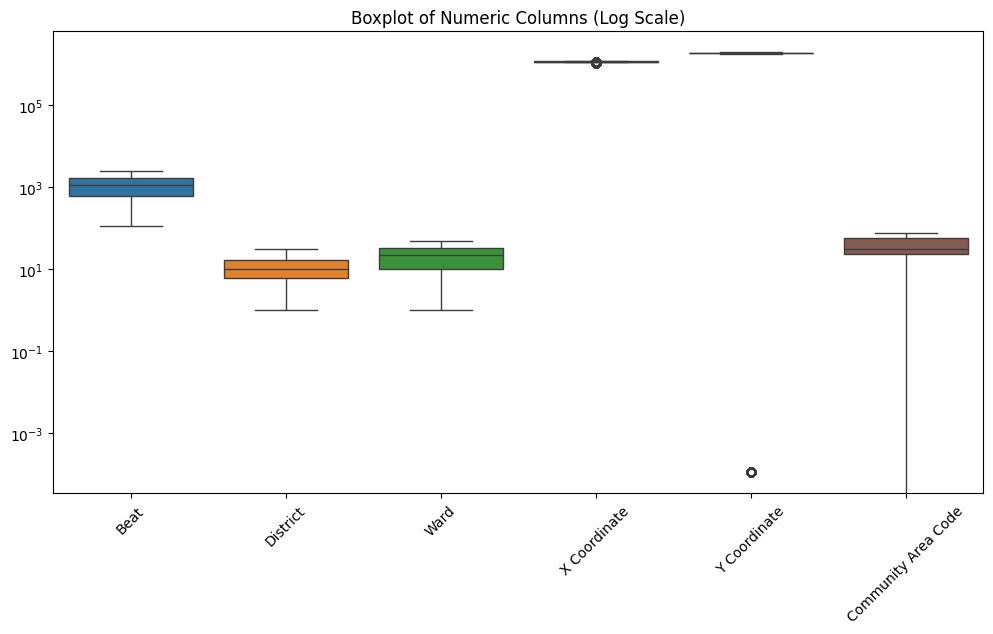

In [ ]:
def boxplot_numeric_cols_logscale(df):
    # 1. 수치형 컬럼만 고르기 (is_narcotics 제외)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'is_narcotics']

    # 2. 박스플롯 그리기
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[numeric_cols])

    # 3. y축 로그 스케일 적용
    plt.yscale('log')
    plt.title("Boxplot of Numeric Columns (Log Scale)")
    plt.xticks(rotation=45)  # x축 라벨 45도 꺾기
    plt.show()

boxplot_numeric_cols_logscale(df)

In [ ]:
# Community Area Code의 이상치 확인
print(df['Community Area Code'].describe())
print(df['Community Area Code'].value_counts().sort_index())

# Community Area Code의 경우 값이 1번부터 77번까지 분포되어 있어야 하나, 0이라는 이상치가 존재

# Community Area Code가 1 이상인 데이터만 남기기
df = df[df['Community Area Code'] >= 1].reset_index(drop=True)

count    6.167824e+06
mean     3.758538e+01
std      2.153326e+01
min      0.000000e+00
25%      2.300000e+01
50%      3.200000e+01
75%      5.800000e+01
max      7.700000e+01
Name: Community Area Code, dtype: float64
Community Area Code
0       305
1     95964
2     75811
3     93180
4     43525
      ...  
73    72256
74    13980
75    49118
76    34011
77    61561
Name: count, Length: 78, dtype: int64


In [ ]:
# Y좌표의 이상치 확인
df['Y Coordinate'].describe()

# 1만 이하인 데이터 보기
small_y = df[df['Y Coordinate'].astype(float) < 10000]
print(small_y[['Y Coordinate']])

# 이상치 행 개수 확인
print("1만 이하 데이터 개수:", len(small_y))

# 1만 이하 좌표값 제거
df = df[df['Y Coordinate'].astype(float) >= 10000]

         Y Coordinate
6740          0.00011
6741          0.00011
6742          0.00011
6746          0.00011
6747          0.00011
...               ...
5689135       0.00011
5854950       0.00011
5920569       0.00011
5997692       0.00011
6156713       0.00011

[246 rows x 1 columns]
1만 이하 데이터 개수: 246


## (5) 비슷한 칼럼 간 다중공선성 여부 확인하기

In [ ]:
# 현재 공간 관련 데이터를 담고 있는 칼럼들이 많아, VIF 계산해보기

# VIF 계산할 칼럼만 추리기
location_cols = [
    'Beat', 'District', 'Ward', 'X Coordinate', 'Y Coordinate', 'Community Area Code'
]

X_location = df[location_cols]

# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = X_location.columns
vif_data['VIF'] = [variance_inflation_factor(X_location.values, i) for i in range(X_location.shape[1])]

print(vif_data)

               feature          VIF
0                 Beat    31.346241
1             District    34.412270
2                 Ward     8.155742
3         X Coordinate  3353.381814
4         Y Coordinate  3433.556833
5  Community Area Code     6.832567


- **Beat, District: 둘 중 하나만 남기기**
- Ward, Community Area Code: 둘 다 남길 예정
- X Coordinate, Y Coordinate: 다중공선성에 예민하지 않은 트리 계열의 모델들에서 둘 다 그대로 사용 예정

In [ ]:
# 사용하려는 모델들(랜덤 포레스트, XGBoost, LightGBM)은 모두 트리 계열 모델들임
# 따라서 중요도의 평균을 내서 Beat, District 중 하나만 남길 예정

# 모델 정의
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss', tree_method='hist')
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 앙상블 모델 (soft voting)
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
    voting='soft',  # 확률 기반 소프트 보팅
    n_jobs=-1
)

# 학습 (X: Beat, District 두 feature만 / y: 타겟)
X_compare = df[['Beat', 'District']]
y_compare = df['is_narcotics']

voting_clf.fit(X_compare, y_compare)

# 개별 모델 꺼내서 feature importance 가져오기
rf_fitted = voting_clf.named_estimators_['rf']
xgb_fitted = voting_clf.named_estimators_['xgb']
lgbm_fitted = voting_clf.named_estimators_['lgbm']

# 중요도 추출
importance_rf = rf_fitted.feature_importances_
importance_xgb = xgb_fitted.feature_importances_
importance_lgbm = lgbm_fitted.feature_importances_

# 평균 중요도 계산
importance_avg = np.mean([importance_rf, importance_xgb, importance_lgbm], axis=0)

# 결과 정리
importance_df = pd.DataFrame({
    'feature': ['Beat', 'District'],
    'importance': importance_avg
}).sort_values(by='importance', ascending=False)

print(importance_df)

    feature  importance
0      Beat  909.006039
1  District   91.660628


- 트리 계열 모델들인 랜덤 포레스트, LightGBM, XGBoost를 넣은 앙상블 모델로 Beat / District의 중요도를 평균 계산해 본 결과,
  - Beat의 중요성이 더 높음

**- 결론: District는 드랍 예정**

In [ ]:
# District 컬럼 드랍
df = df.drop(columns=['District'])

## (6) 최종 데이터 타입 변환 및 범주형 변수 인코딩

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6167273 entries, 0 to 6167518
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Location Description  object 
 1   Arrest                bool   
 2   Domestic              bool   
 3   Beat                  int64  
 4   Ward                  int64  
 5   X Coordinate          float64
 6   Y Coordinate          float64
 7   Community Area Code   int64  
 8   is_narcotics          uint8  
dtypes: bool(2), float64(2), int64(3), object(1), uint8(1)
memory usage: 347.0+ MB


In [ ]:
# 인코딩 전, 메모리를 더 효율적으로 사용하기 위해 데이터 타입 최종적으로 한 번 더 변환

# 숫자형 칼럼은 int32로 변환
df[['Beat', 'Ward', 'Community Area Code']] = \
    df[['Beat', 'Ward', 'Community Area Code']].astype('int32')

# X, Y좌표는 float32로 변환
df[['X Coordinate', 'Y Coordinate']] = \
    df[['X Coordinate', 'Y Coordinate']].astype('float32')

# is_narcotics는 bool로 변환
df['is_narcotics'] = df['is_narcotics'].astype('bool')

In [ ]:
# 메모리를 효율적으로 사용하기 위한 바이너리 인코딩 진행

from category_encoders import BinaryEncoder

binary_cols = ['Location Description', 'Beat', 'Ward', 'Community Area Code']

# 인코딩
binary_encoder = BinaryEncoder(cols=binary_cols)
encoded_binary = binary_encoder.fit_transform(df[binary_cols])

# 기존 칼럼 제거
df = df.drop(columns=binary_cols)

# 메모리 복사를 최소화하면서 합치기
df = pd.concat([df, encoded_binary], axis=1, copy=False)

# 머신러닝(랜덤 포레스트, XGBoost, LightGBM)

In [ ]:
# 마약범죄가 아닌 데이터, 맞는 데이터의 불균형이 심함 -> 그러나, 오버/언더샘플링 또는 smote를 진행하면 데이터가 왜곡될 수 있음.
# 진행하지 않고 바로 학습시킨다!
df['is_narcotics'].value_counts()

,count
is_narcotics,
False,5492966
True,674307


In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X = df.drop(columns=['is_narcotics'])
y = df['is_narcotics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 랜덤 포레스트 모델 사용
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.99      0.95   1098601
        True       0.79      0.31      0.44    134854

    accuracy                           0.91   1233455
   macro avg       0.85      0.65      0.70   1233455
weighted avg       0.91      0.91      0.90   1233455



In [ ]:
# XGBoost 모델 사용

model = XGBClassifier(
    max_depth=10,
    learning_rate=0.05,
    n_estimators=1000,
    tree_method='gpu_hist',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.96      0.96   1098601
        True       0.70      0.71      0.71    134854

    accuracy                           0.94   1233455
   macro avg       0.83      0.84      0.84   1233455
weighted avg       0.94      0.94      0.94   1233455



In [ ]:
# LightGBM 모델 사용
import lightgbm as lgb
from sklearn.metrics import classification_report

lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True)  # 50번 동안 개선 없으면 멈춤
]

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=callbacks
)

y_pred = lgbm_model.predict(X_test)

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 539453, number of negative: 4394365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.350958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 4933818, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109338 -> initscore=-2.097523
[LightGBM] [Info] Start training from score -2.097523
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's binary_logloss: 0.133788
              precision    recall  f1-score   support

       False       0.96      0.96      0.96   1098601
        True       

In [ ]:
# 랜덤 포레스트, XGBoost, LightGBM을 모두 합친 앙상블 모델
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)

lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist',   # GPU 없으면 hist, 있으면 gpu_hist
    predictor='gpu_predictor',
    verbosity=0
)

voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lgbm', lgbm_model),
        ('xgb', xgb_model)
    ],
    voting='soft',    # soft: 확률 기반 투표
    n_jobs=-1
)

voting_model.fit(X_train, y_train)

y_pred = voting_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.97      0.96   1098601
        True       0.72      0.64      0.68    134854

    accuracy                           0.93   1233455
   macro avg       0.84      0.81      0.82   1233455
weighted avg       0.93      0.93      0.93   1233455



In [ ]:
# 모델별 마약범죄 예측 성능 결과를 표로 정리
data = {
    "Model": ["RandomForest", "XGBoost", "LightGBM", "Voting Ensemble"],
    "Accuracy": [0.91, 0.94, 0.93, 0.93],
    "Precision": [0.79, 0.70, 0.70, 0.72],
    "Recall": [0.31, 0.71, 0.70, 0.64],
    "F1-score": [0.44, 0.71, 0.70, 0.68],
}

model_performance_df = pd.DataFrame(data)
model_performance_df

- **가장 성능이 좋은 모델은 XGBoost**로, 해당 모델 기반으로 하이퍼 파라미터 튜닝 시도

- 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1] 옵션으로 그리드 서치 진행 결과
  - Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'subsample': 0.8}
  - Best Precision Score: 0.6960728166880491
  - 오히려 Precision 수치가 떨어짐

- 또한, 성능을 높이기 위해 기본 임계치인 0.5 대신 0.8을 적용해보았지만, 여전히 성능을 올리지는 못했음